<a href="https://colab.research.google.com/github/ThePingPing/Basic_for_deep_learnig/blob/main/Transfer_Learning_and_Freeze_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Final Project Data science
# By Dan Cohen  
Transfer Learning Model

Transfer learning is a machine learning technique that involves using knowledge gained from solving one task to improve performance on another related task. Instead of building a model from scratch for each new task, transfer learning leverages the knowledge already acquired by a pre-trained model on a similar task.

The fundamental idea behind transfer learning is that deep learning models learn general data representations when trained on large datasets. These representations capture generic and abstract features of the data, which can be reused to solve other problems.

Here's why transfer learning is an extremely powerful tool:

Less training data required: Since the pre-trained model has already learned general features from a large dataset, it typically requires less training data to adapt to a new task. This is especially advantageous when dealing with small or costly-to-obtain new datasets.

Reduced time and computational power: The initial pre-training of a deep model on a large dataset can be computationally expensive and time-consuming. By using transfer learning, we can save these resources and focus on fine-tuning the model for the new task, which is usually faster.

Improved performance: Pre-trained models are already capable of capturing important features and general patterns in the data. By utilizing this prior knowledge, the transferred model can benefit from better initialization and achieve higher performance more quickly than training from scratch.

Why use transfer learning for datasets with similar problems:

When two datasets have similar characteristics or are from related domains, transfer learning can be particularly beneficial. Here are some reasons why transfer learning is effective in such cases:

Shared high-level representations: Pre-trained models on similar problems tend to learn high-level features that are common to those problems. By transferring this knowledge, the model can benefit from a more effective initialization for the target task.

Learning specific features: Deep layers of neural networks tend to learn low-level features (such as edges or textures) in early layers, followed by increasingly abstract features in higher layers. The low-level features learned on a similar dataset can be reused to learn task-specific features for the new task.

Improved generalization: Transfer learning promotes generalization, meaning the transferred model is more likely to perform well on new data that is not exactly the same as the data it was trained on.

In summary, transfer learning is a powerful tool to leverage prior knowledge acquired from solving similar problems, reduce data requirements, and improve model performance on new tasks. It is widely used in machine learning and particularly useful in domains where data is scarce or datasets are similar.

Why I decided to transfer learning from EMNIST to FMNIST

Limited data availability: EMNIST is a large dataset with various handwritten characters, while FMNIST is a dataset of fashion-related images (clothing items). Since both datasets share some similarities, such as grayscale images and classification tasks, you might have chosen transfer learning to leverage the knowledge gained from EMNIST to improve the performance on FMNIST, especially if FMNIST has a smaller dataset size.

Similar feature representations: Convolutional Neural Networks (CNNs) learn hierarchical feature representations from data. Features learned from recognizing handwritten characters in EMNIST might be useful in capturing low-level patterns in FMNIST images of clothing. Transfer learning allows you to reuse these common features and fine-tune the model for a different but related task.

Reduced training time and resources: Training a deep learning model from scratch on FMNIST can be computationally expensive and time-consuming. By utilizing a pre-trained model from EMNIST as the starting point, you can save considerable training time and resources, as the model has already learned generic image features.






In [275]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary

from torch.optim import Adam, SGD

from sklearn.model_selection import train_test_split

import sklearn.metrics as skm

import time

import copy

In [276]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

This line of code checks if a GPU is available (torch.cuda.is_available()) and sets the device (device) accordingly: "cuda:0" if a GPU is available, otherwise "cpu". This allows leveraging the GPU's power to accelerate computations during model training and inference in Deep Learning models.

In [277]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 2            |        cudaMalloc retries: 3         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   3418 MiB |  12550 MiB |  27121 GiB |  27118 GiB |\n|       from large pool |   3407 MiB |  12537 MiB |  23888 GiB |  23885 GiB |\n|       from small pool |     11 MiB |     20 MiB |   3232 GiB |   3232 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   3418 MiB |  12550 MiB |  27121 GiB |  27118 GiB |\n|       from large pool |   3407 MiB |  12537 MiB |

In [278]:
init_numbers_epochs = 10
tranfer_numbers_epochs = 1
name_model_Emnist = "Emnist"
name_model_full_retrained = "Fmnist Fully"
name_model_freeze = "Fmnist Freeze"
color_full_retrained = "Blues"
color_freeze_retrained = "OrRd"

##################### MODEL STARTING #########################

The provided code defines an architecture for a Convolutional Neural Network (CNN) model for the EMNIST dataset. Below is a description of the model's architecture

CNN Model: The model is based on a CNN architecture, which is well-suited for extracting relevant features from images, like those in the EMNIST dataset.

Convolution Layers: The model uses three convolutional layers, each followed by a max-pooling layer. The convolutional layers detect patterns and important features in the images, while max-pooling layers reduce the spatial size of feature maps, enabling the model to learn more global features and improve training efficiency.

Batch Normalization: After each convolutional layer, a batch normalization layer is used. Batch normalization normalizes the activations from the previous layers, which helps accelerate training convergence and improve model stability.

Activation Functions: The ReLU (Rectified Linear Unit) activation function is used after each convolutional and batch normalization layer. ReLU is commonly used in CNNs as it allows for nonlinear learning while avoiding the vanishing gradient problem.

Flatten Layer: After the convolutional layers, the data is flattened to be transformed into vectors before being fed into the subsequent fully connected layers.

Fully Connected Layers: The model employs three fully connected linear layers for the final classification. These layers take the features learned by the convolutional layers and produce probabilities for each character class.

In [279]:
def CreateTheEmnistModelConv(printtoggle=False):

    class emistnet(nn.Module):

        def __init__(self, printtoggle):
            super().__init__()

            """ for the Toggle """
            self.print = printtoggle

            ### ----------- Model Structure ------------ ###

            ##the Size output conv1 = np.floor((sizeImg + (2 * padding - Kernel_size) / stride_size ) +1) --> MaxPOOL

            self.conv1_layer = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)  # output size: ((28+2*1-3)/1 + 1) / 2 = 28 /2 = 14, Start with 64 Kernels Map
            self.batch_normalize1 = nn.BatchNorm2d(64)

            self.conv2_layer = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)  # output size: ((14+2*0-3)/1 + 1) / 2 = 12 /2 = 6
            self.batch_normalize2 = nn.BatchNorm2d(128)

            self.conv3_layer = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0)  # output size: ((6+2*0-3)/1 + 1) / 2 = 4 / 2 = 2
            self.batch_normalize3 = nn.BatchNorm2d(256)

            ### -------------- Linear Layers ------------ ###

            """ number_units_input = out_channels * (2 ** outputSize last convolution)"""

            number_units_input = 256 * (2**2)


            self.linear1 = nn.Linear(number_units_input, 256)
            self.linear2 = nn.Linear(256, 64)
            self.output = nn.Linear(64, 26)

        def forward(self, x):

            if self.print: print(f'Input:{list(x.shape)}')

            # first block : convolution --> maxpooling -->. batch normalization --> relu / leakyRelu

            x = F.max_pool2d(self.conv1_layer(x), 2)
            x = F.relu(self.batch_normalize1(x)) ## i decide to normalize before to change the varience



            # Second block : convolution --> maxpooling -->. batch normalization --> relu / leakyRelu

            x = F.max_pool2d(self.conv2_layer(x), 2)
            x = F.relu(self.batch_normalize2(x))


            if self.print: print(f'Pass to Second Block:{list(x.shape)}')

            # Threes block : convolution --> maxpooling -->. batch normalization --> relu / leakyRelu

            x = F.max_pool2d(self.conv3_layer(x), 2)
            x = F.relu(self.batch_normalize3(x))


            if self.print: print(f'Pass to Threes Block:{list(x.shape)}')

            number_unites = x.shape.numel() / x.shape[0] ## Calculat the numbers of units from the the last layer  x = F.relu(self.batch_normalize3(x)) " The total numbers of elements / total numbers of data samples"
            x = x.view(-1, int(number_unites)) ## reshpe X to be a matrix to be the Batch siZe (32) by the total number of units

            if self.print: print(f' Fllaten to Vectors :{list(x.shape)}')

            ## ------- to Linear Layers --------- ##

            x = F.relu(self.linear1(x))
            x = F.relu(self.linear2(x))
            x = self.output(x)

            if self.print: print(f' After the linear Block  :{list(x.shape)}')

            return x

    ModelEmnist = emistnet(printtoggle)

    return ModelEmnist

In [280]:
def create_image_data_emnist():

    data_emnist = torchvision.datasets.EMNIST(root="emnist", split="letters", download=True)

    # print(data_emnist.classes) ## print the Data Letters
    #
    # print(str(len(data_emnist.classes)) + "Classes" )
    # print(data_emnist.data.shape) ## check the shape


    """converte the torch.Size([124800, 28, 28]) for a tensor 4D , 1 chane so [124800, 1, 28, 28]l and of course int to float if not you can used in the model """

    data_images_emnist = data_emnist.data.view([124800, 1, 28, 28]).float()
    # print(data_images_emnist.shape)
    #print(data_images_emnist) ## Check the Matrixs images values

    """ Now check if N/A Categorie Have Data """

    # print(torch.sum(data_emnist.targets == 0)) ## ==> tensor(0) So you 0 Image with this label, you can Delete this features No Problem

    """ ==> tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26]) That a problem , coz the LOSS FUNCTION gonna convert to one hot incoding , so we have to start in 0 """
    # print(torch.unique(data_emnist.targets))


    """Remove The N/A classes , juste reindex the target """

    # print(data_emnist.class_to_idx)

    data_letters_categories = data_emnist.classes[1:]

    labels_emnist = copy.deepcopy(data_emnist.targets) - 1

    # print(torch.sum(labels_emnist == 0)) ## ==> check it's the A letters Target

    return data_images_emnist, data_letters_categories, labels_emnist

In [281]:
def create_image_data_fmnist():

    data_fmnist = torchvision.datasets.FashionMNIST(root="fmnist", download=True)

    data_images_fmnist = data_fmnist.data.view([60000, 1, 28, 28]).float()
    labels_fmnist = copy.deepcopy(data_fmnist.targets)
    data_fashion_categories = data_fmnist.classes[:]

    return data_images_fmnist, data_fashion_categories, labels_fmnist

In [282]:
data_images_emnist, data_letters_categories, labels_emnist = create_image_data_emnist()
data_images_fmnist, data_fashion_categories, labels_fmnist = create_image_data_fmnist()

The provided code consists of two function calls: create_image_data_emnist() , and create_image_data_fmnist(). These functions generate and organize the data for two datasets: EMNIST and FMNIST (Fashion MNIST).

The data for each dataset is stored in the corresponding variables: data_images_emnist, data_letters_categories, labels_emnist, data_images_fmnist, data_fashion_categories, and labels_fmnist. Let's provide a brief explanation of each variable and its role:

data_images_emnist: This variable contains the image data for the EMNIST dataset. The images represent characters (letters) in the dataset.

data_letters_categories: This variable holds the categories (labels) for the EMNIST dataset. Each label corresponds to the category (letter) represented by the respective image in data_images_emnist.

labels_emnist: This variable stores the labels for the EMNIST dataset in a different format. It likely serves as a one-hot encoded representation of the categories in data_letters_categories.

data_images_fmnist: This variable contains the image data for the FMNIST (Fashion MNIST) dataset. The images represent various fashion items (e.g., clothing).

data_fashion_categories: This variable stores the categories (labels) for the FMNIST dataset. Each label corresponds to the category (fashion item) represented by the respective image in data_images_fmnist.

labels_fmnist: Similar to labels_emnist, this variable likely holds the labels for the FMNIST dataset in a one-hot encoded format.

In summary, the provided code executes two functions to create and organize image data and their corresponding labels for the EMNIST and FMNIST datasets. The resulting variables allow for further analysis and modeling of the respective datasets.

In [283]:
def plot_values_images(data_images_emnist, data_images_fmnist):

    fig, axs = plt.subplots(2, 2, figsize=(13, 8))
    axs[0,0].hist(data_images_emnist[:10, :, :, :].view(1, -1).detach(), 40)
    axs[0,0].set_title("Row Value Original EMNIST")
    data_images_emnist /= torch.max(data_images_emnist)
    axs[0,1].hist(data_images_emnist[:10, :, :, :].view(1, -1).detach(), 40)
    axs[0,1].set_title("Row Value after Normalization EMNIST")

    axs[1,0].hist(data_images_fmnist[:10, :, :, :].view(1, -1).detach(), 40)
    axs[1,0].set_title("Row Value Original FMNIST")
    data_images_fmnist /= torch.max(data_images_fmnist)
    axs[1,1].hist(data_images_fmnist[:10, :, :, :].view(1, -1).detach(), 40)
    axs[1,1].set_title("Row Value after Normalization FMNIST")

    plt.show()


Data normalization in convolutional models is essential to ensure stable learning, accelerate convergence, and improve model generalization. Without normalization, it may lead to learning difficulties, slow convergence, overfitting, and imbalanced gradients. In summary, normalization is crucial for achieving better performance and facilitating optimization in convolutional models.






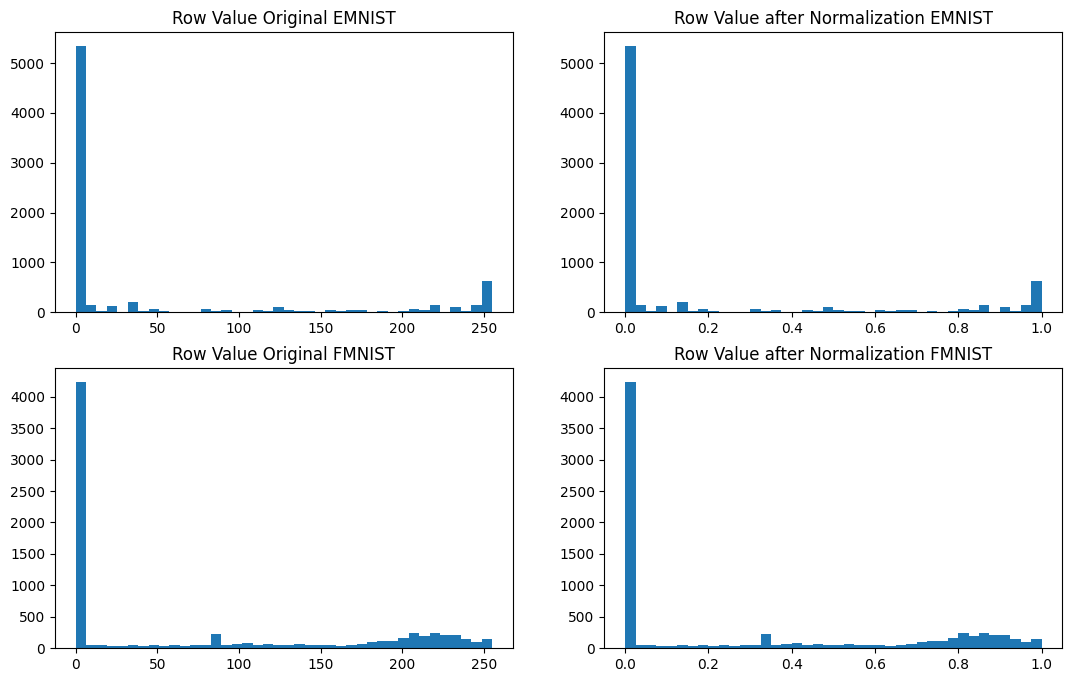

In [284]:
plot_values_images(data_images_emnist, data_images_fmnist)

Here we plot on a histograme the distribuation of the Values Images from the 10 first images in the data sets  before and after Normalization

In [285]:
def plot_some_images_emnist(data_images_emnist, data_letters_categories, labels_emnist):

    fig, axs = plt.subplots(3, 7, figsize=(14, 7))

    for i, ax in enumerate(axs.flatten()):
        random_images = np.random.randint(data_images_emnist.shape[0])
        image_extract = np.squeeze(data_images_emnist[random_images, :, :])
        letter = data_letters_categories[labels_emnist[random_images]]

        ax.imshow(image_extract.T, cmap="gray")
        ax.set_title('The Letter "%s"' %letter)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

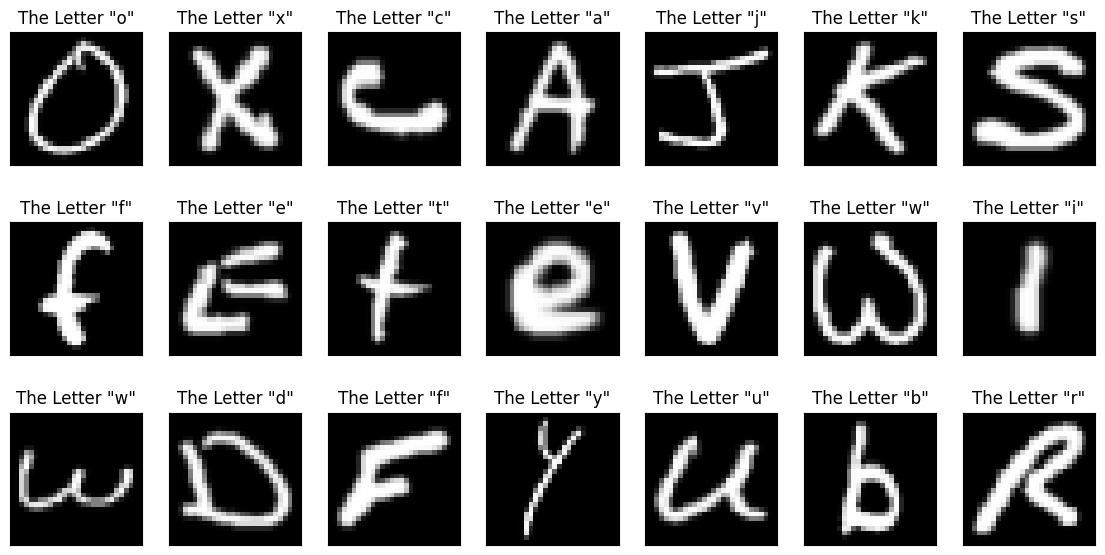

In [286]:
plot_some_images_emnist(data_images_emnist, data_letters_categories, labels_emnist)

Here we just plot somes Random images from the Data set EMNIST

In [287]:
def plot_some_images_fmnist(data_images_fmnist, data_fashion_categories, labels_fmnist):

    fig, axs = plt.subplots(3, 7, figsize=(18, 7))

    for i, ax in enumerate(axs.flatten()):
        random_images = np.random.randint(data_images_fmnist.shape[0])
        image_extract = np.squeeze(data_images_fmnist[random_images, :, :])
        fashion = data_fashion_categories[labels_fmnist[random_images]]

        ax.imshow(image_extract, cmap="gray")
        ax.set_title('Fashion "%s"' %fashion)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

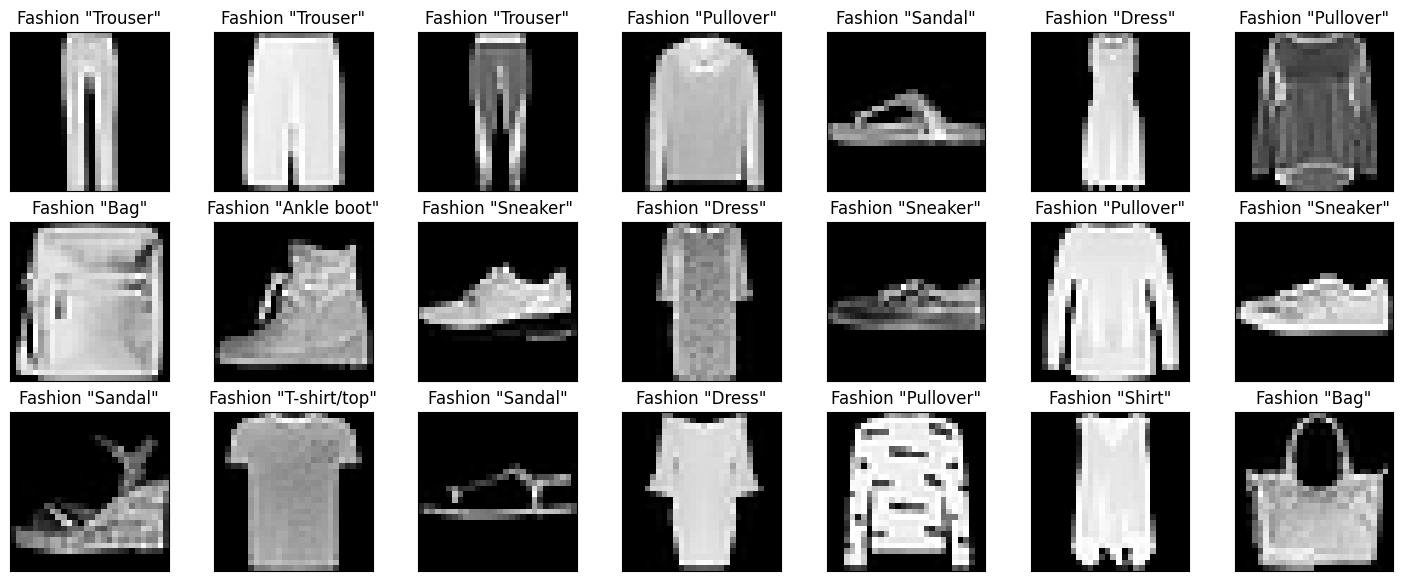

In [288]:
plot_some_images_fmnist(data_images_fmnist, data_fashion_categories, labels_fmnist)

Here we just plot somes Random images from the Data set FMNIST

In [289]:
def data_loader_convert(data_images_emnist, labels_emnist, data_images_fmnist, labels_fmnist):

    X_train, X_test, y_train, y_test = train_test_split(data_images_emnist, labels_emnist, train_size=0.9)
    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(data_images_fmnist, labels_fmnist, train_size=0.9)

    # then convert them into PyTorch Datasets (note: already converted to tensors)
    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)

    train_data_f = TensorDataset(X_train_f, y_train_f)
    test_data_f = TensorDataset(X_test_f, y_test_f)

    batchsize = 32

    train_loader_emnist = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
    test_loader_emnist = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

    train_loader_fmnist = DataLoader(train_data_f, batch_size=batchsize, shuffle=True, drop_last=True)
    test_loader_fmnist = DataLoader(test_data_f, batch_size=test_data.tensors[0].shape[0])



    print("Train loader EMNIST : ",  train_loader_emnist.dataset.tensors[0].shape)
    print("Test loader EMNIST : ", test_loader_emnist.dataset.tensors[1].shape)

    print("Train loader FMNIST : ", train_loader_fmnist.dataset.tensors[0].shape)
    print("Test loader FMNIST : ", test_loader_fmnist.dataset.tensors[1].shape)

    return train_loader_emnist, test_loader_emnist, train_loader_fmnist, test_loader_fmnist

In [290]:
train_loader_emnist, test_loader_emnist, train_loader_fmnist, test_loader_fmnist = data_loader_convert(data_images_emnist, labels_emnist, data_images_fmnist, labels_fmnist)

Train loader EMNIST :  torch.Size([112320, 1, 28, 28])
Test loader EMNIST :  torch.Size([12480])
Train loader FMNIST :  torch.Size([54000, 1, 28, 28])
Test loader FMNIST :  torch.Size([6000])


Data Splitting: The function splits the EMNIST and FMNIST datasets into training and testing subsets using the train_test_split function from the scikit-learn library. It assigns 90% of the data to the training sets (X_train and X_train_f) and 10% to the testing sets (X_test and X_test_f).

Conversion to PyTorch Datasets: The function converts the training and testing data of both datasets (X_train, y_train, X_test, y_test, X_train_f, y_train_f, X_test_f, y_test_f) into PyTorch Datasets using TensorDataset. PyTorch Datasets are objects that provide an interface to access the data during training and evaluation.

Data Loading: The function then creates DataLoader objects for both EMNIST and FMNIST datasets using the DataLoader class from PyTorch. DataLoaders help efficiently load the data in mini-batches during training. The training DataLoader (train_loader_emnist and train_loader_fmnist) is shuffled, and the last batch is dropped if it's not full (drop_last=True). The testing DataLoader (test_loader_emnist and test_loader_fmnist) is not shuffled and is set to load the entire testing set in one batch.

Printing Data Shapes: The function prints the shapes of the training and testing data for both EMNIST and FMNIST datasets.

Return: Finally, the function returns four DataLoader objects (train_loader_emnist, test_loader_emnist, train_loader_fmnist, test_loader_fmnist) that can be used for training and evaluation in PyTorch models.

In summary, the data_loader_convert function takes image data and their corresponding labels for both EMNIST and FMNIST datasets, splits them into training and testing sets, converts them

In [291]:
def initialize_model():

    ModelEmnist = CreateTheEmnistModelConv(False)
    loss_function = nn.CrossEntropyLoss() ## Multi Classification task
    learning_rate = (10 ** -3)
    optimizer = Adam(ModelEmnist.parameters(), lr=learning_rate)



    return ModelEmnist, loss_function, optimizer

In [292]:
ModelEmnist, loss_function, optimizer = initialize_model()

Creating the Model: The function calls the CreateTheEmnistModelConv function to create a convolutional neural network (CNN) model specific to the EMNIST dataset. The model is assigned to the variable ModelEmnist.

Loss Function: The function sets the loss function to nn.CrossEntropyLoss(). Cross-entropy loss is commonly used for multi-class classification problems like the EMNIST dataset. This loss function computes the cross-entropy between the predicted class probabilities and the ground truth labels.

Learning Rate and Optimizer: The learning rate is set to (10 ** -3), which means 0.001. The optimizer chosen for training the model is Adam. Adam is an adaptive learning rate optimization algorithm widely used for training deep learning models. It helps to adjust the learning rate based on the gradients of the model's parameters.

Return: The function returns three objects: ModelEmnist (the CNN model), loss_function (the cross-entropy loss function), and optimizer (the Adam optimizer).

In summary, the initialize_model function sets up the CNN model, defines the loss function, and selects the Adam optimizer with a learning rate of 0.001. These components are then used for training the model on the EMNIST dataset.

In [293]:
def test_model(ModelEmnist, loss_function, train_loader):

    X, y = next(iter(train_loader))
    yHat = ModelEmnist(X)
    loss = loss_function(yHat, torch.squeeze(y))

    print(" ")
    print("yHat Shape", yHat.shape) ## ==> Yhat Shape torch.Size([32, 26]) It's Normal Coz batch size is 32 , and 26 letters
    print(" Thes loss ", loss)
    print(summary(ModelEmnist.to(device), (1, 28, 28)))


In [294]:
test_model(ModelEmnist, loss_function, train_loader_emnist)

 
yHat Shape torch.Size([32, 26])
 Thes loss  tensor(3.2679, grad_fn=<NllLossBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 14, 14]             128
            Conv2d-3          [-1, 128, 12, 12]          73,856
       BatchNorm2d-4            [-1, 128, 6, 6]             256
            Conv2d-5            [-1, 256, 4, 4]         295,168
       BatchNorm2d-6            [-1, 256, 2, 2]             512
            Linear-7                  [-1, 256]         262,400
            Linear-8                   [-1, 64]          16,448
            Linear-9                   [-1, 26]           1,690
Total params: 651,098
Trainable params: 651,098
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.70
Params si

the test_model function evaluates the CNN model ModelEmnist on a single batch of training data from the train_loader. It calculates the cross-entropy loss between the model's predictions and the actual labels and prints the shape of the predictions (yHat) and the computed loss. This function can be used to get an initial assessment of the model's performance on the training data. However, for a comprehensive evaluation, it's necessary to test the model on the test dataset as well.

In [295]:
def train_model(Model, loss_function, optimizer, train_loader, test_loader, numbers_epochs, name):


    ## Implement a new model , never see any data
    start_time = time.time()


    ## Push to GPU
    Model.to(device)

    # number of epochs

    ## initialize losses
    train_Loss = torch.zeros(numbers_epochs)
    test_Loss = torch.zeros(numbers_epochs)
    train_error = torch.zeros(numbers_epochs)
    test_error = torch.zeros(numbers_epochs)

    ## loop over epochs
    for epochi in range(numbers_epochs):

        # loop over training data batches
        Model.train()
        batch_loss = []
        batch_error = []
        for X, y in train_loader:

            # push data to the GPU

            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = Model(X)
            loss = loss_function(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batch_loss.append(loss.item())
            batch_error.append(torch.mean((torch.argmax(yHat, axis=1) != y).float()).item()) ## you can change to == if you prefere to see the Accuracy rate
        # end of batch loop...

        # and get average losses across the batches
        train_Loss[epochi] = np.mean(batch_loss)
        train_error[epochi] = 100 * np.mean(batch_error)

        # test accuracy
        Model.eval()
        X, y = next(iter(test_loader))  # extract X,y from test dataloader

        # push data to the GPU
        X = X.to(device)
        y = y.to(device)
        print("Im Still learn the Epoch Number is :", epochi)

        with torch.no_grad():  # deactivates autograd
            yHat = Model(X)
            loss = loss_function(yHat, y)

        test_Loss[epochi] = loss.item()
        test_error[epochi] = 100 * torch.mean((torch.argmax(yHat, axis=1) != y).float()).item()

    # end epochs
    ModelTrained = Model
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("The time computing for the Model training / retrainig is --> ", elapsed_time, " for the Model : ", name)

    # function output
    return ModelTrained, train_Loss, test_Loss, train_error, test_error

In [296]:
ModelEmnistTrained, train_Loss, test_Loss, train_error, test_error = train_model(ModelEmnist, loss_function, optimizer, train_loader_emnist, test_loader_emnist, init_numbers_epochs, name_model_Emnist)

Im Still learn the Epoch Number is : 0
Im Still learn the Epoch Number is : 1
Im Still learn the Epoch Number is : 2
Im Still learn the Epoch Number is : 3
Im Still learn the Epoch Number is : 4
Im Still learn the Epoch Number is : 5
Im Still learn the Epoch Number is : 6
Im Still learn the Epoch Number is : 7
Im Still learn the Epoch Number is : 8
Im Still learn the Epoch Number is : 9
The time computing for the Model training / retrainig is -->  139.2916965484619  for the Model :  Emnist


Pushing the Model to GPU: The Model is moved to the GPU (if available) using ModelEmnist.to(device). This enables the training to be performed on the GPU, which can significantly speed up the computation.

Initialization and Data Preparation: The function initializes variables to store training and testing losses, as well as training and testing error rates. It then enters a loop for the number of specified epochs (numbers_epochs).

Training Loop: For each epoch, the function loops over the batches of training data (X and y) in the train_loader. It performs the following steps for each batch:

Pushes the batch data to the GPU.
Performs a forward pass through the model to get predictions (yHat).
Computes the loss between the predictions (yHat) and the ground truth labels (y).
Backpropagates the gradients and updates the model's parameters using the specified optimizer.
Calculating Training Loss and Error: After processing all batches in an epoch, the function calculates the average training loss and error rate for that epoch.

Testing the Model: The function then evaluates the trained model on the test data from the test_loader. It performs a forward pass on the test data to get predictions (yHat) and computes the loss and error rate on the test data.

Printing Epoch Information: The function prints the current epoch number during training.

Function Output: After completing all epochs, the function returns the trained model (ModelTrained) along with the lists of training and testing losses (train_Loss and test_Loss) and training and testing error rates (train_error and test_error).

In summary, the train_model function takes a deep learning model, loss function, optimizer, and data loaders for training and testing. It then trains the model for the specified number of epochs, calculates the training and testing losses, and computes the training and testing error rates. Finally, it returns the trained model and the metrics collected during the training process.

In [297]:
def plot_train_result(train_Loss, test_Loss, train_error, test_error, name):

    fig, ax = plt.subplots(1, 2, figsize=(13, 4))

    ax[0].plot(train_Loss, 's-', label='Train loss')
    ax[0].plot(test_Loss, 'o-', label='Test loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('epoch')
    ax[0].set_title('Losses '+ name)
    ax[0].legend()

    ax[1].plot(train_error, 's-', label='Train, Error')
    ax[1].plot(test_error, 'o-', label='Test Error, ')
    ax[1].set_ylabel('Error rate (%)')
    ax[1].set_xlabel('Epoch')
    ax[1].set_title('Error')
    ax[1].set_title(f'Final model test Error: {test_error[-1]:.2f}% ' + name)
    ax[1].legend()
    plt.show()

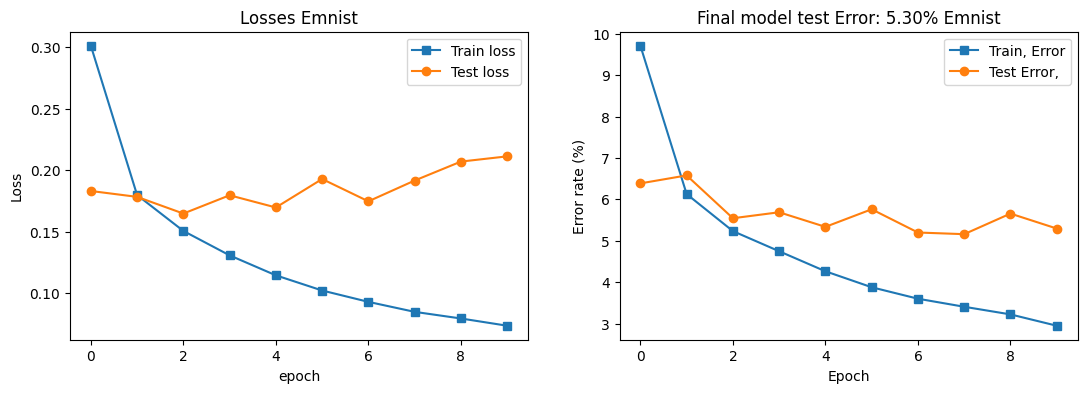

In [298]:
plot_train_result(train_Loss, test_Loss, train_error, test_error, name_model_Emnist)

unction creates a visual representation of the training and testing losses, as well as the training and testing error rates, over the epochs. It provides a quick and informative way to analyze the model's performance during training and testing phases.

In [299]:
def plot_the_mistake_image_predicted(ModelEmnistTrained, test_loader, data_letters_categories):

  X, y = next(iter(test_loader))

  X = X.to(device)
  y = y.to(device)

  yHat = ModelEmnistTrained(X)

  ## Take a few random Exemples

  list_rand_ex = np.random.choice(len(y), size=21, replace=False)

  fig, axs = plt.subplots(3, 7, figsize=(14, 7))

  for i, ax in enumerate(axs.flatten()):

      image_extract = np.squeeze(X[list_rand_ex[i], 0, :, :]).cpu()
      true_letters_cat = data_letters_categories[y[list_rand_ex[i]]]
      predict_letters_cat = data_letters_categories[torch.argmax(yHat[list_rand_ex[i], :])]
      color = "gray" if true_letters_cat == predict_letters_cat else "hot"

      ax.imshow(image_extract.T, cmap=color)
      ax.set_title(' Real L  %s, pred L %s' % (true_letters_cat, predict_letters_cat), fontsize=10)
      ax.set_xticks([])
      ax.set_yticks([])

  plt.show()
  return y, yHat




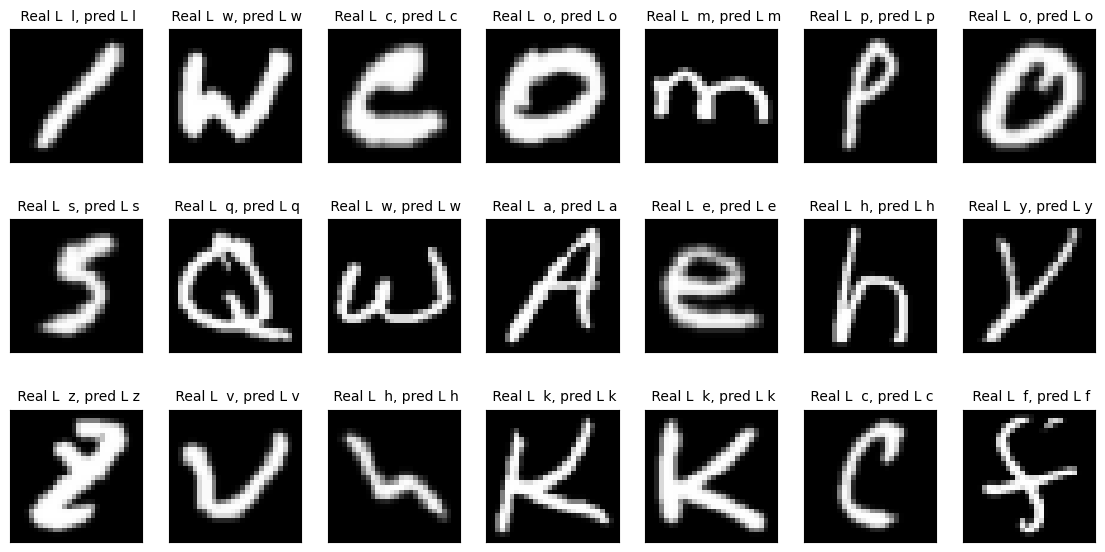

In [300]:
y, yHat = plot_the_mistake_image_predicted(ModelEmnistTrained, test_loader_emnist, data_letters_categories)

function allows visual inspection of randomly selected test examples and their corresponding true and predicted letter categories. It helps to identify cases where the model makes mistakes in its predictions, which can be insightful for further model analysis and improvement.

In [301]:
def show_matrix_confusion_emnist(y, yHat, name, color):
  ### And For the Final we look on the confusion Matrix to Know , witch letters not predict correctly ###

  confusion_matrix = skm.confusion_matrix(y.cpu(), torch.argmax(yHat.cpu(), axis=1), normalize="true")

  fig = plt.figure(figsize=(10, 10))
  plt.imshow(confusion_matrix, cmap = color, vmax=0.05)

  ## Laout Design ##

  plt.xticks(range(26), labels=data_letters_categories)
  plt.yticks(range(26), labels=data_letters_categories)
  plt.title("Confusion Matrix " + name)
  plt.xlabel("Real Letters")
  plt.ylabel("Predicted Letters")

  plt.show()


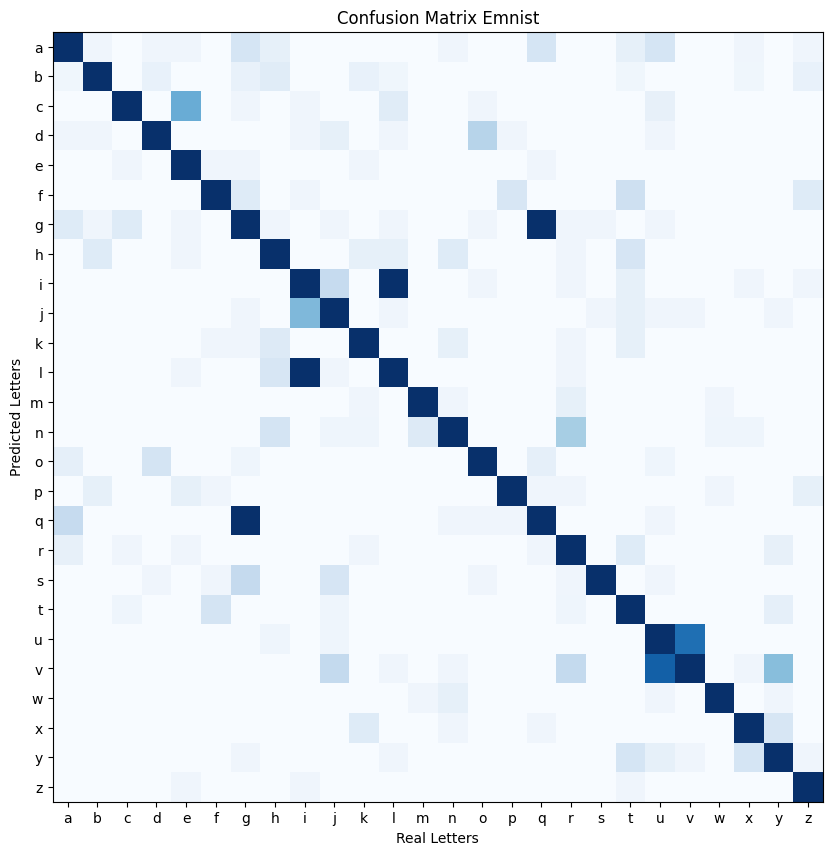

In [302]:
show_matrix_confusion_emnist(y, yHat, name_model_Emnist, color_full_retrained)

 the confusion matrix, allowing easy analysis of the model's performance in classifying letters in the EMNIST dataset. The confusion matrix shows correct and incorrect predictions for each letter in the dataset, which can be valuable for assessing the overall performance of the model.


#################### NOW The TRANFER LEARNING ################################

In [303]:
def test_fashion_on_ModelEmnist(ModelEmnistTrained, test_loader_fmnist):

    print("FROM TEST MODEL WITH FASHION TEST LOADER")

    X, y = next(iter(test_loader_fmnist))
    X = X.to(device)
    y = y.to(device)

    yHat = ModelEmnistTrained(X)

    accuracy_fashion = 100 * torch.mean((torch.argmax(yHat, axis=1) == y).float())
    print(f'ModelEmnistTrained performance on FASHION data: {accuracy_fashion:.2f}%')

In [304]:
test_fashion_on_ModelEmnist(ModelEmnistTrained, test_loader_fmnist)

FROM TEST MODEL WITH FASHION TEST LOADER
ModelEmnistTrained performance on FASHION data: 7.38%


 function evaluates the trained CNN model (ModelEmnistTrained) on the FMNIST dataset and prints the accuracy of the model's predictions on that dataset. This allows the comparison of the model's performance on different datasets, EMNIST and FMNIST in this case, of course before de tranfer learning

In [305]:
def transfer_learning_model(ModelEmnistTrained):

    ModelFmnist, loss_function, optimizer = initialize_model()

    """Reintialized all the target model weight from the Source model already Trained"""

    for target, source in zip(ModelFmnist.named_parameters(), ModelEmnistTrained.named_parameters()):
        target[1].data = copy.deepcopy(source[1].data)

    ModelFmnist.linear3 = nn.Linear(64, 10)

    print("From ModelFmnist parameters : ", ModelFmnist)
    print(summary(ModelFmnist.to(device), (1, 28, 28)))

    return ModelFmnist, loss_function, optimizer

In [306]:
ModelFmnist, loss_function, optimizer = transfer_learning_model(ModelEmnistTrained)

From ModelFmnist parameters :  emistnet(
  (conv1_layer): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_normalize1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch_normalize2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (batch_normalize3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=1024, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=26, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28

The function transfer_learning_model is used to create a new model (ModelFmnist) for the FMNIST dataset by transferring the weights learned from a pre-trained model (ModelEmnistTrained)

Input: The function takes one argument:

ModelEmnistTrained: The pre-trained CNN model (source model) from which the weights will be transferred.
Model Initialization: The function calls the initialize_model() function, which returns a new EMNIST model (ModelFmnist), a loss function (loss_function), and an optimizer (optimizer).

Weight Transfer: The function performs weight transfer from the ModelEmnistTrained to the ModelFmnist. It loops through the named parameters of both models and copies the weights from the source model to the target model using deepcopy. This process transfers all the pre-trained convolutional layers' weights from EMNIST to FMNIST.

Adjusting Output Layer: The ModelFmnist has a different output layer size than ModelEmnistTrained because FMNIST has 10 classes (for different fashion items) instead of 26 classes (for letters in EMNIST). To adapt the model to FMNIST, the last fully connected layer (linear3) of ModelFmnist is replaced with a new nn.Linear layer that has 64 input units (matching the previous layer's output) and 10 output units (matching the number of classes in FMNIST).

Printing Model Summary: The function prints the parameters of the new ModelFmnist after the weight transfer and the adjustment of the output layer.

Moving Model to GPU: The ModelFmnist is moved to the GPU (device) for computation.

Function Output: The function returns the new FMNIST model (ModelFmnist) along with the loss function (loss_function) and optimizer (optimizer) to be used for training the model on the FMNIST dataset.

In [307]:
ModelFmnistTrained, train_Loss_f, test_Loss_f, train_error_f, test_error_f = train_model(ModelFmnist, loss_function, optimizer, train_loader_fmnist, test_loader_fmnist, tranfer_numbers_epochs, name_model_full_retrained)

Im Still learn the Epoch Number is : 0
The time computing for the Model training / retrainig is -->  6.845382213592529  for the Model :  Fmnist Fully


retraining the model for a limited number of epochs, we leverage the prior knowledge from the pre-trained EMNIST model to expedite the learning process on FMNIST while avoiding overfitting and enabling a more targeted adaptation to the new dataset.

This approach enables us to obtain a specialized and high-performing model for the clothing classification task on FMNIST.

And we print the time it took for the model to be completely retrained over a restricted number of epochs

In [308]:
def transfer_freeze_learning_model(ModelEmnistTrained):

    ModelFmnistFreeze, loss_function, optimizer = initialize_model()

    """Reintialized all the target model weight from the Source model already Trained"""

    for target, source in zip(ModelFmnistFreeze.named_parameters(), ModelEmnistTrained.named_parameters()):
        target[1].data = copy.deepcopy(source[1].data)

    ModelFmnistFreeze.linear3 = nn.Linear(64, 10)

    """ We will freeze all layers that are not linear layers."""

    for p in ModelFmnistFreeze.named_parameters():
      if("conv" in p[0]) or ("batch_normalize" in p[0]):
        p[1].requires_grad = False

    print("From ModelFmnistFreeze parameters : ", ModelFmnistFreeze)

    return ModelFmnistFreeze.to(device), loss_function, optimizer

In [309]:
ModelFmnistFreeze, loss_function, optimizer = transfer_freeze_learning_model(ModelEmnistTrained)

From ModelFmnistFreeze parameters :  emistnet(
  (conv1_layer): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_normalize1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch_normalize2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (batch_normalize3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=1024, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=26, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)


The transfer_freeze_learning_model function is used to create a new model (ModelFmnistFreeze) for the FMNIST dataset by transferring weights learned from a pre-trained model (ModelEmnistTrained)

But it's different from the transfer_learning_model function. Here, we will freeze the Convolutional layers and batch normalization layers to only retrain the linear layers

In this step, specific layers of ModelFmnistFreeze are frozen to prevent further training. Convolutional layers and batch normalization layers are typically frozen by setting their requires_grad attribute to False. This means that the weights of these layers will not be updated during training.

To compare the results between training the entire model and only the linear layers.
And we print the time it took for the model to retrained only the Linear Layers a restricted number of epochs

In [310]:
ModelFmnistFreezeTrained, train_Loss_f_freeze, test_Loss_f_freeze, train_error_f_freeze, test_error_f_freeze = train_model(ModelFmnistFreeze, loss_function, optimizer, train_loader_fmnist, test_loader_fmnist, tranfer_numbers_epochs, name_model_freeze)

Im Still learn the Epoch Number is : 0
The time computing for the Model training / retrainig is -->  4.5252907276153564  for the Model :  Fmnist Freeze


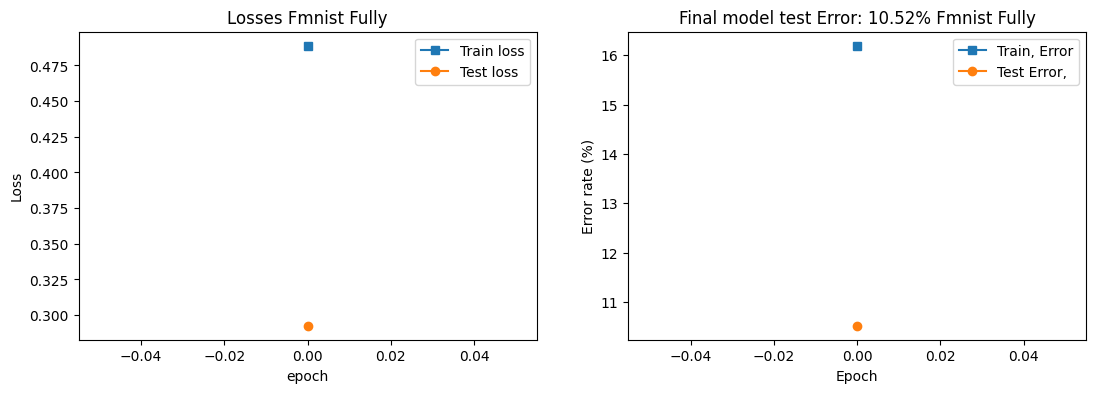

In [311]:
plot_train_result(train_Loss_f, test_Loss_f, train_error_f, test_error_f, name_model_full_retrained)

We reuse the function plot_train_result to visualize the error rate obtained after one epoch of training on the new pre-trained model following transfer learning.

Here, we can observe the power of transfer learning, with an extremely low error rate, even though only one epoch of training has been performed.


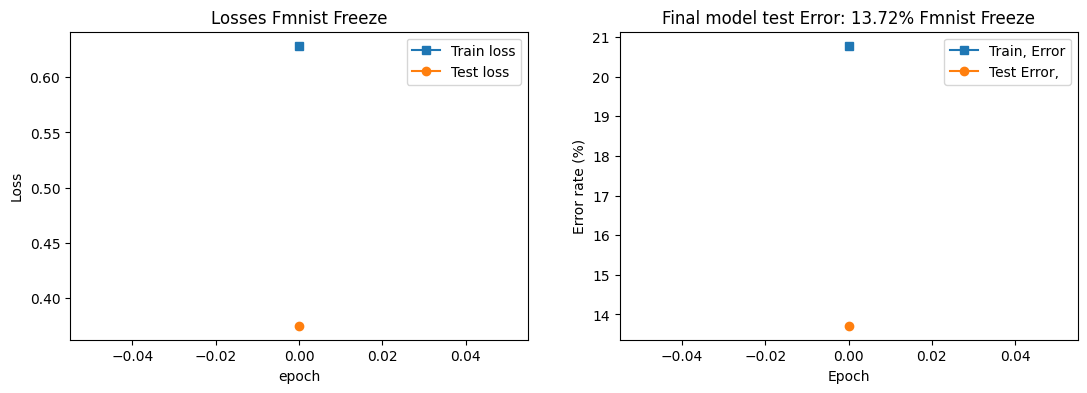

In [312]:
plot_train_result(train_Loss_f_freeze, test_Loss_f_freeze, train_error_f_freeze, test_error_f_freeze, name_model_freeze)

Here we can see the error rate when the model is retrained, but only on the linear layers.

In [313]:
def plot_the_mistake_image_predicted_fashion(ModelFmnistTrained, test_Loss_f, data_fashion_categories):

    X, y = next(iter(test_Loss_f))

    X = X.to(device)
    y = y.to(device)
    yHat = ModelFmnistTrained(X)

    ## Take a few random Exemples

    list_rand_ex = np.random.choice(len(y), size=21, replace=False)

    fig, axs = plt.subplots(3, 7, figsize=(24, 7))

    for i, ax in enumerate(axs.flatten()):

        image_extract = np.squeeze(X[list_rand_ex[i], 0, :, :]).cpu()
        true_fashion_cat = data_fashion_categories[y[list_rand_ex[i]]]
        predict_fashion_cat = data_fashion_categories[torch.argmax(yHat[list_rand_ex[i], :])]
        color = "gray" if true_fashion_cat == predict_fashion_cat else "hot"

        ax.imshow(image_extract, cmap=color)
        ax.set_title(' Real f %s, pred f %s' % (true_fashion_cat, predict_fashion_cat), fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    return y, yHat


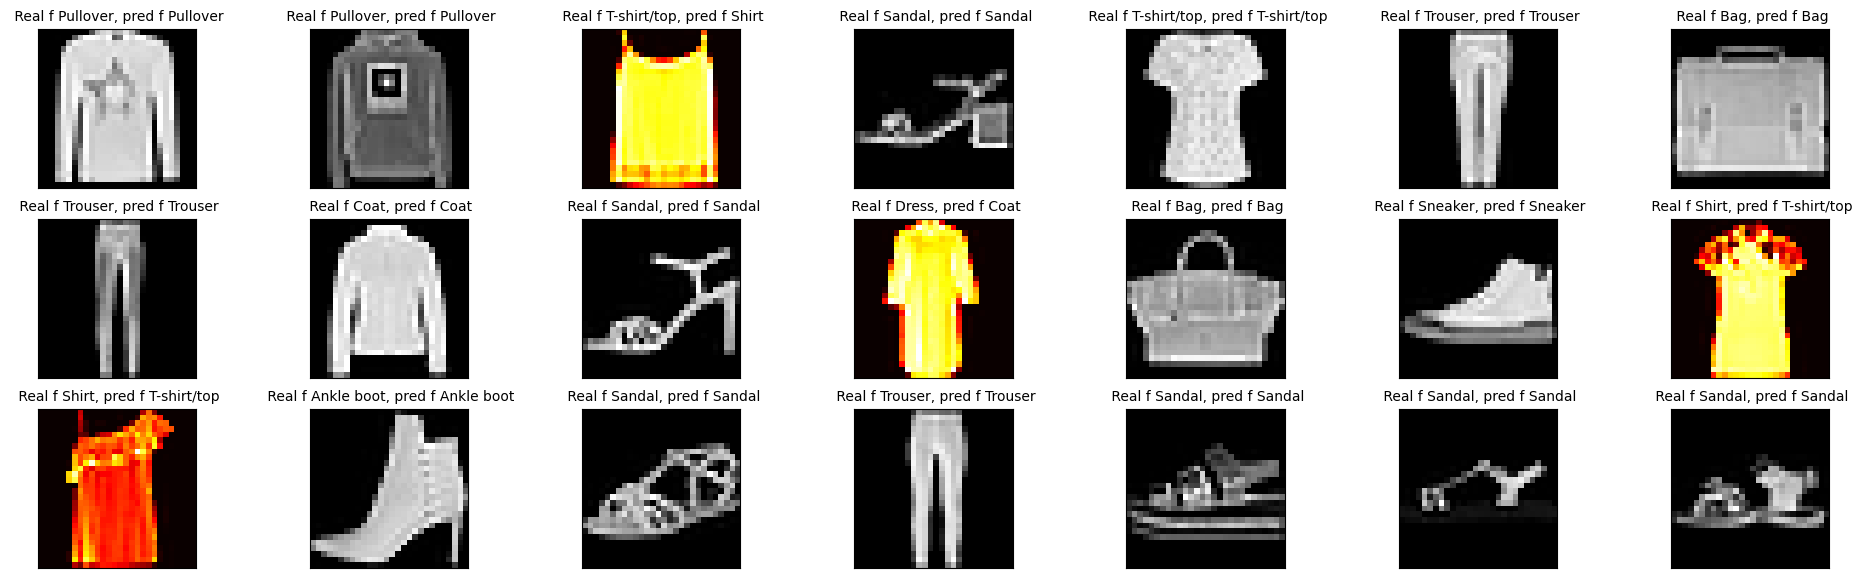

In [323]:
y, yHat = plot_the_mistake_image_predicted_fashion(ModelFmnistTrained, test_loader_fmnist, data_fashion_categories)

 visual inspection of randomly selected test examples and their corresponding true and predicted Fashion categories When the model has been completely retrained for 1 epoch

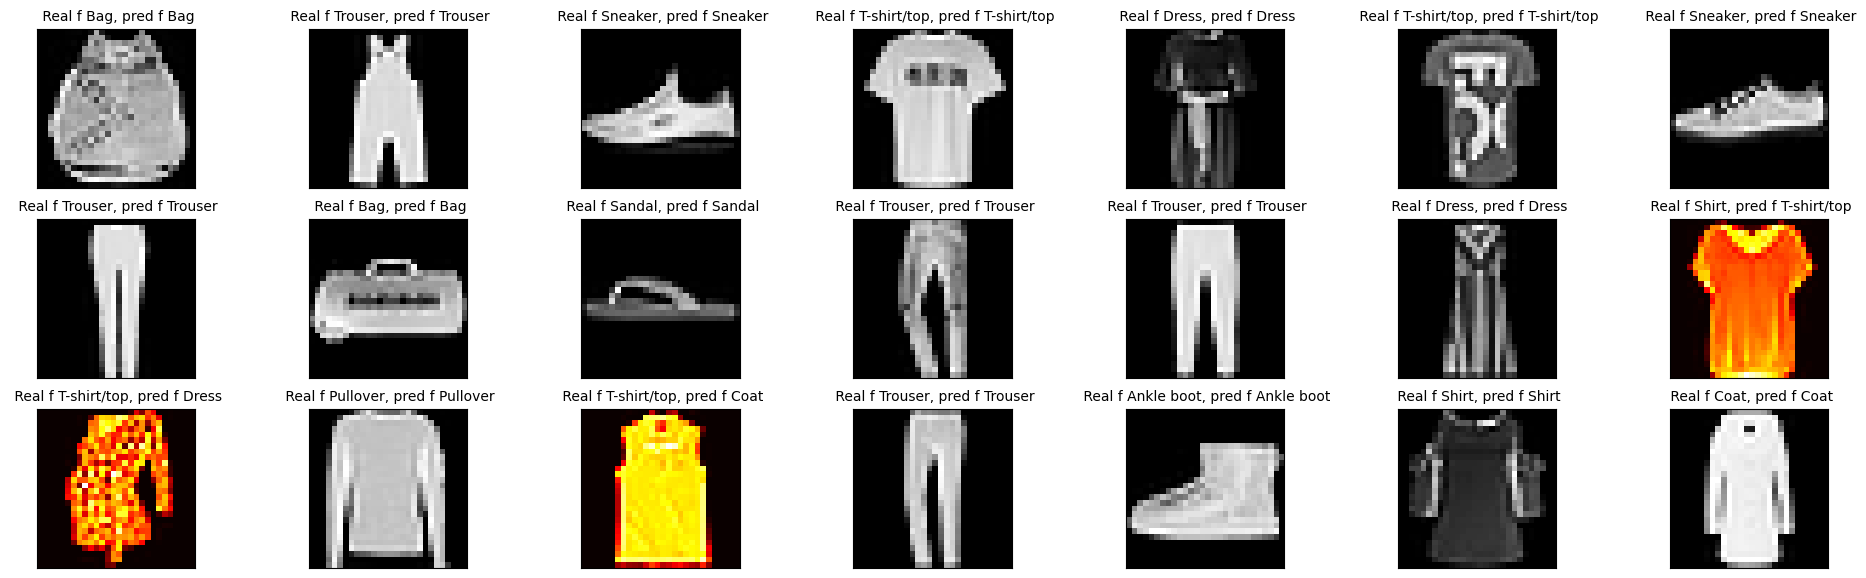

In [324]:
y_freeze, yHat_freeze = plot_the_mistake_image_predicted_fashion(ModelFmnistFreezeTrained, test_loader_fmnist, data_fashion_categories)

In [316]:
def show_matrix_confusion_fmnist(y, yHat, name, color):

    confusion_matrix = skm.confusion_matrix(y.cpu(), torch.argmax(yHat.cpu(), axis=1), normalize="true")

    fig = plt.figure(figsize=(8, 8))
    plt.imshow(confusion_matrix, cmap = color, vmax=0.05)

    ## Laout Design ##

    plt.xticks(range(10), labels=data_fashion_categories)
    plt.yticks(range(10), labels=data_fashion_categories)
    plt.title("Confusion Matrix"+ name)
    plt.xlabel("Real Fashion")
    plt.ylabel("Predicted Fashion")

    plt.show()

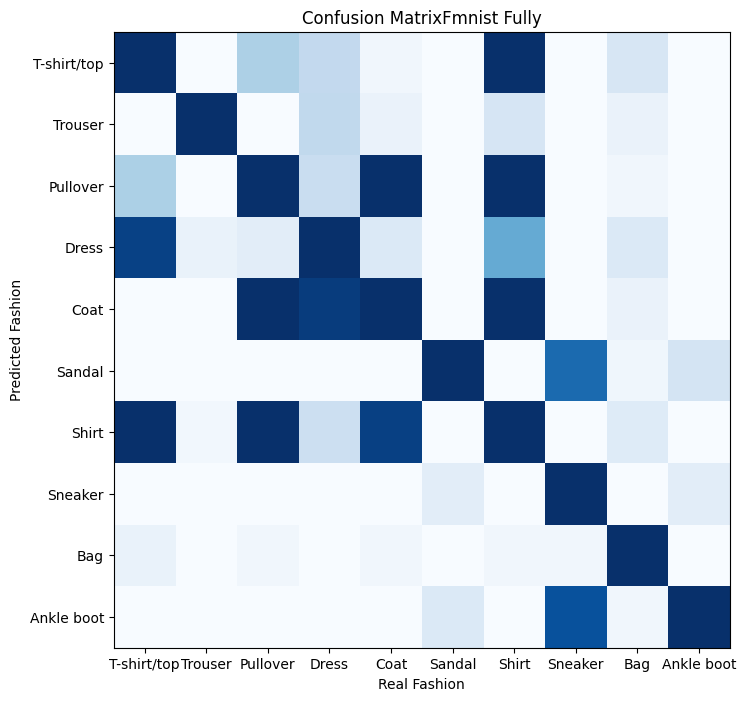

In [317]:
show_matrix_confusion_fmnist(y, yHat, name_model_full_retrained, color_full_retrained)

And finaly the confision Matrix for the FMNIST completely retrained

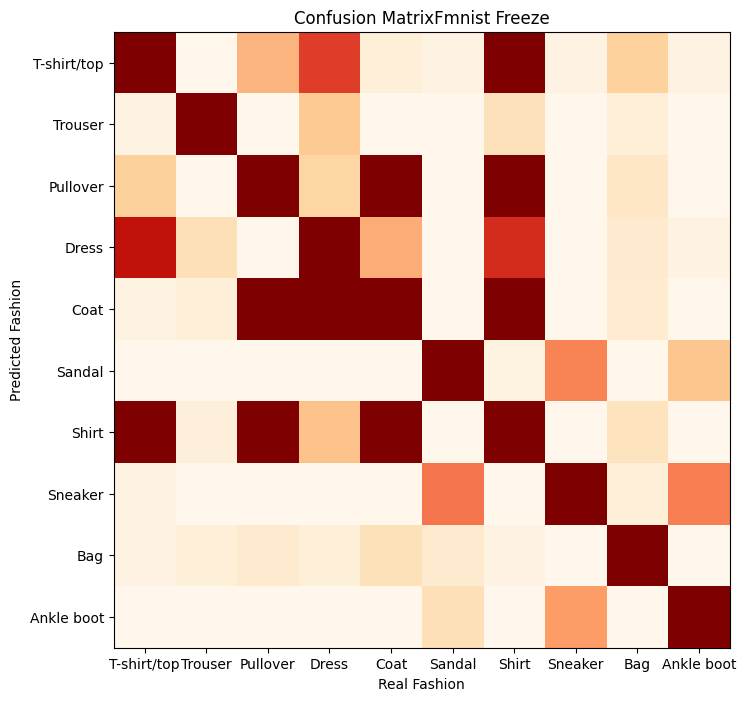

In [318]:
show_matrix_confusion_fmnist(y_freeze, yHat_freeze, name_model_freeze, color_freeze_retrained)

And Here confision Matrix for the FMNIST Freeze retrained

# Conclusion

Our experiment has demonstrated that Transfer Learning is a powerful tool that allows us to reuse the learning from a model trained on one dataset for use on another dataset by transferring the weights and biases of the model.

In summary, with minor changes and adjustments, we achieved truly remarkable results. Not to mention the considerable time savings compared to the effort it would have taken to implement an entirely new model.

Furthermore, the experience presented here suggests that it is preferable to completely Retraining the new model for a limited number of epochs

follows that the time saved by training only the linear layers of the model for one epoch results in a time saving of approximately one second, but the loss of performance averages around 4% based on these results
The time saved in comparison to the loss in performance is not convincing.